### Use the Asynchronous Advantage Actor Critic (A3C) Policy Gradient Method to solve Breakout

In [146]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import lfilter

import progressbar as pb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

from torchsummary import summary

In [2]:
env_id = 'BreakoutDeterministic-v4'
env = gym.make(env_id)

In [3]:
env.observation_space

Box(210, 160, 3)

In [4]:
print(f"Actions:{env.action_space}\nMeanings:{env.unwrapped.get_action_meanings()}")

Actions:Discrete(4)
Meanings:['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #convert to GPU if available

## Preprocess Image

In [6]:
## Utils
def preprocess_single_frame(image, bkg_color = np.array([144, 72, 17])):
    """
    Converts an image from RGB channel to B&W channels.
    Also performs downscale to 80x80. Performs normalization.
    @Param:
    1. image: (array_like) input image. shape = (210, 160, 3)
    2. bkg_color: (np.array) standard encoding for brown in RGB with alpha = 0.0
    @Return:
    - img: (array_like) B&W, downscaled, normalized image of shape (80x80)
    """
    img = np.mean(image[35:195:2,::2]-bkg_color, axis=-1)/255.
    return img

#Utils
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    """
    convert outputs of parallelEnv to inputs to pytorch neural net"""
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

In [7]:
state = env.reset()
for _ in range(20):#skip 20 frames
    frame, _, _, _ = env.step(np.random.randint(0, env.action_space.n))

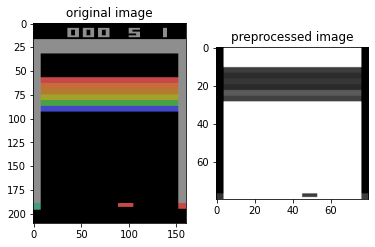

In [8]:
#Plot processed and raw image
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')
# 80 x 80 black and white image
plt.imshow(preprocess_single_frame(frame), cmap='Greys')
plt.show()

# Actor-Critic

<img height=500 width=500 src="https://www.mdpi.com/energies/energies-09-00725/article_deploy/html/images/energies-09-00725-g001-1024.png">

In [138]:
#DEFINE Constants
GAMMA = 0.99
TAU = 1.0

In [96]:
class ActorCritic(nn.Module):
    def __init__(self, action_size=4, num_frames=2):
        super(ActorCritic, self).__init__()
        self.action_size = action_size
        
        #Define the CNN for Actor & Critic
        self.conv1 = nn.Conv2d(num_frames, 32, 3, stride=2, padding=1) #output = 40x40x32
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 20x20x32
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 10x10x32
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 5x5x32
        
        self.size = 5*5*32 #800

        #FC layer
        self.lstm = nn.LSTMCell(input_size=self.size, hidden_size=512)#lstm cell to prevent vanishing gradients
        
        # Define Actor and Critic network
        # Critic evaluates the state value function, V(π) using TD estimate.
        # Actor evaluates the policy π(a|s) distribution
        
        self.critic_linear, self.actor_linear = nn.Linear(512, 1), nn.Linear(512, self.action_size)
        
    def forward(self, x, hx, cx):
        """
        Peforms one-pass for the Conv layers.
        @Param:
        1. x - shape: (2, 80, 80); 2 stacked frames of 80x80 images
        2. hx - hidden state of the RNN. shape: (800x512)
        3. cx - confidence state of the RNN. shape: (800x512)
        @Return:
        1. critic estimated value, V(π)
        2. actor policy distribution, π(a|s) as logits
        """
        #4 conv nets without max pool layers, simple Relu activation f(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        print(x.shape)
        x = x.view(-1,self.size) #flatten
        print(x.shape)
        hx, cx = self.lstm(x, (hx, cx)) #dynamic calculation for final confidence & hidden state
        value = self.critic_linear(hx) #CRITIC: calculates estimated state value function, V(π)
        logits = self.actor_linear(hx) #ACTOR:  calculates policy distribution π(a|s)
        
        return logits, value, hx, cx

In [97]:
agent = ActorCritic()

# Optimizer
<p> A critical component to an A3C model is the ability to share parameters across
    multiple agents running asynchronously such that they can collectively learn from
    each other. This is done by the cross-integration (sharing) of gradients across all processes.
</p>

In [136]:
class SharedOptimizer(optim.Adam):
    """Implementation of shared parameter model using Adam optimizer"""
    def __init__(self, params, lr=0.001):
        super(SharedOptimizer, self).__init__(params)
        for group in self.param_groups:
            for params in group['params']:
                state = self.state[params]
                state['step'] = 0
                state['exp_avg'] = torch.zeros_like(params.data).share_memory_()
                state['exp_avg_sq'] = torch.zeros_like(params.data).share_memory_()

In [137]:
optimizer = SharedOptimizer(agent.parameters()) #define optimizer (uses Adam, instead of SGD)

## Generalized Advantage Estimator 
<br>
<p>
    Generalized Advantage Estimator (GAE) helps us pick the best value for N-step boostrapping
    by incorporating λ as an added hyper-parameter to tune accordingly that will minimize the
    bias-variance tradeoff.
    <br>
    The derivation can be thought of as <a href="https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/#the-generalized-advantage-estimator">the exponentially-decayed sum of residual terms.</a>
</p>
<p><strong>See the following <a href="https://arxiv.org/pdf/1506.02438.pdf">derivation</a> for GAE estimator:</strong></p>
<br>

<span class="MathJax" id="MathJax-Element-48-Frame" tabindex="0" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mtable columnalign=&quot;right left right left right left right left right left right left&quot; rowspacing=&quot;3pt&quot; columnspacing=&quot;0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em&quot; displaystyle=&quot;true&quot;><mtr><mtd><msubsup><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>A</mi><mo stretchy=&quot;false&quot;>&amp;#x005E;</mo></mover></mrow><mi>t</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>G</mi><mi>A</mi><mi>E</mi><mo stretchy=&quot;false&quot;>(</mo><mi>&amp;#x03B3;</mi><mo>,</mo><mi>&amp;#x03BB;</mi><mo stretchy=&quot;false&quot;>)</mo></mrow></msubsup></mtd><mtd><mi></mi><mo>=</mo><mo stretchy=&quot;false&quot;>(</mo><mn>1</mn><mo>&amp;#x2212;</mo><mi>&amp;#x03BB;</mi><mo stretchy=&quot;false&quot;>)</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.623em&quot; minsize=&quot;1.623em&quot;>(</mo></mrow><msubsup><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>A</mi><mo stretchy=&quot;false&quot;>&amp;#x005E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>t</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo stretchy=&quot;false&quot;>(</mo><mn>1</mn><mo stretchy=&quot;false&quot;>)</mo></mrow></msubsup><mo>+</mo><mi>&amp;#x03BB;</mi><msubsup><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>A</mi><mo stretchy=&quot;false&quot;>&amp;#x005E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>t</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo stretchy=&quot;false&quot;>(</mo><mn>2</mn><mo stretchy=&quot;false&quot;>)</mo></mrow></msubsup><mo>+</mo><msup><mi>&amp;#x03BB;</mi><mn>2</mn></msup><msubsup><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>A</mi><mo stretchy=&quot;false&quot;>&amp;#x005E;</mo></mover></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>t</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo stretchy=&quot;false&quot;>(</mo><mn>3</mn><mo stretchy=&quot;false&quot;>)</mo></mrow></msubsup><mo>+</mo><mo>&amp;#x22EF;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.623em&quot; minsize=&quot;1.623em&quot;>)</mo></mrow></mtd></mtr><mtr><mtd /><mtd><mi></mi><mo>=</mo><mo stretchy=&quot;false&quot;>(</mo><mn>1</mn><mo>&amp;#x2212;</mo><mi>&amp;#x03BB;</mi><mo stretchy=&quot;false&quot;>)</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.623em&quot; minsize=&quot;1.623em&quot;>(</mo></mrow><msubsup><mi>&amp;#x03B4;</mi><mi>t</mi><mi>V</mi></msubsup><mo>+</mo><mi>&amp;#x03BB;</mi><mo stretchy=&quot;false&quot;>(</mo><msubsup><mi>&amp;#x03B4;</mi><mi>t</mi><mi>V</mi></msubsup><mo>+</mo><mi>&amp;#x03B3;</mi><msubsup><mi>&amp;#x03B4;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>t</mi><mo>+</mo><mn>1</mn></mrow><mi>V</mi></msubsup><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><msup><mi>&amp;#x03BB;</mi><mn>2</mn></msup><mo stretchy=&quot;false&quot;>(</mo><msubsup><mi>&amp;#x03B4;</mi><mi>t</mi><mi>V</mi></msubsup><mo>+</mo><mi>&amp;#x03B3;</mi><msubsup><mi>&amp;#x03B4;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>t</mi><mo>+</mo><mn>1</mn></mrow><mi>V</mi></msubsup><mo>+</mo><msup><mi>&amp;#x03B3;</mi><mn>2</mn></msup><msubsup><mi>&amp;#x03B4;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>t</mi><mo>+</mo><mn>2</mn></mrow><mi>V</mi></msubsup><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mo>&amp;#x22EF;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.623em&quot; minsize=&quot;1.623em&quot;>)</mo></mrow></mtd></mtr><mtr><mtd /><mtd><mi></mi><mo>=</mo><mo stretchy=&quot;false&quot;>(</mo><mn>1</mn><mo>&amp;#x2212;</mo><mi>&amp;#x03BB;</mi><mo stretchy=&quot;false&quot;>)</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.623em&quot; minsize=&quot;1.623em&quot;>(</mo></mrow><msubsup><mi>&amp;#x03B4;</mi><mi>t</mi><mi>V</mi></msubsup><mo stretchy=&quot;false&quot;>(</mo><mn>1</mn><mo>+</mo><mi>&amp;#x03BB;</mi><mo>+</mo><msup><mi>&amp;#x03BB;</mi><mn>2</mn></msup><mo>+</mo><mo>&amp;#x22EF;</mo><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mi>&amp;#x03B3;</mi><msubsup><mi>&amp;#x03B4;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>t</mi><mo>+</mo><mn>1</mn></mrow><mi>V</mi></msubsup><mo stretchy=&quot;false&quot;>(</mo><mi>&amp;#x03BB;</mi><mo>+</mo><msup><mi>&amp;#x03BB;</mi><mn>2</mn></msup><mo>+</mo><mo>&amp;#x22EF;</mo><mo stretchy=&quot;false&quot;>)</mo><mo>+</mo><mo>&amp;#x22EF;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mo maxsize=&quot;1.623em&quot; minsize=&quot;1.623em&quot;>)</mo></mrow></mtd></mtr><mtr><mtd /><mtd><mi></mi><mo>=</mo><mo stretchy=&quot;false&quot;>(</mo><mn>1</mn><mo>&amp;#x2212;</mo><mi>&amp;#x03BB;</mi><mo stretchy=&quot;false&quot;>)</mo><mrow><mo>(</mo><mrow><msubsup><mi>&amp;#x03B4;</mi><mi>t</mi><mi>V</mi></msubsup><mfrac><mn>1</mn><mrow><mn>1</mn><mo>&amp;#x2212;</mo><mi>&amp;#x03BB;</mi></mrow></mfrac><mo>+</mo><mi>&amp;#x03B3;</mi><msubsup><mi>&amp;#x03B4;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>t</mi><mo>+</mo><mn>1</mn></mrow><mi>V</mi></msubsup><mfrac><mi>&amp;#x03BB;</mi><mrow><mn>1</mn><mo>&amp;#x2212;</mo><mi>&amp;#x03BB;</mi></mrow></mfrac><mo>+</mo><mo>&amp;#x22EF;</mo></mrow><mo>)</mo></mrow></mtd></mtr><mtr><mtd /><mtd><mi></mi><mo>=</mo><munderover><mo>&amp;#x2211;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>l</mi><mo>=</mo><mn>0</mn></mrow><mi mathvariant=&quot;normal&quot;>&amp;#x221E;</mi></munderover><mo stretchy=&quot;false&quot;>(</mo><mi>&amp;#x03B3;</mi><mi>&amp;#x03BB;</mi><msup><mo stretchy=&quot;false&quot;>)</mo><mi>l</mi></msup><msubsup><mi>&amp;#x03B4;</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>t</mi><mo>+</mo><mi>l</mi></mrow><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>V</mi></mrow></msubsup></mtd></mtr></mtable></math>" role="presentation" style="text-align: center; position: relative;"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1167" style="width: 38.544em; display: inline-block;"><span style="display: inline-block; position: relative; width: 32.086em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(-4.216em, 1031.72em, 7.971em, -999.997em); top: -2.133em; left: 0em;"><span class="mrow" id="MathJax-Span-1168"><span class="mtable" id="MathJax-Span-1169" style="padding-right: 0.159em; padding-left: 0.159em;"><span style="display: inline-block; position: relative; width: 31.773em; height: 0px;"><span style="position: absolute; clip: rect(5.315em, 1004.01em, 16.305em, -999.997em); top: -11.664em; left: 0em;"><span style="display: inline-block; position: relative; width: 4.013em; height: 0px;"><span style="position: absolute; clip: rect(2.607em, 1004.01em, 4.43em, -999.997em); top: -8.956em; right: 0em;"><span class="mtd" id="MathJax-Span-1170"><span class="mrow" id="MathJax-Span-1171"><span class="msubsup" id="MathJax-Span-1172"><span style="display: inline-block; position: relative; width: 4.013em; height: 0px;"><span style="position: absolute; clip: rect(2.867em, 1000.73em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="texatom" id="MathJax-Span-1173"><span class="mrow" id="MathJax-Span-1174"><span class="munderover" id="MathJax-Span-1175"><span style="display: inline-block; position: relative; width: 0.784em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.73em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1176" style="font-family: MathJax_Math-italic;">A</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.18em, 1000.37em, 3.648em, -999.997em); top: -4.32em; left: 0.263em;"><span class="mo" id="MathJax-Span-1177" style="font-family: MathJax_Main;">^</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1003.23em, 4.326em, -999.997em); top: -4.737em; left: 0.784em;"><span class="texatom" id="MathJax-Span-1178"><span class="mrow" id="MathJax-Span-1179"><span class="mi" id="MathJax-Span-1180" style="font-size: 70.7%; font-family: MathJax_Math-italic;">G</span><span class="mi" id="MathJax-Span-1181" style="font-size: 70.7%; font-family: MathJax_Math-italic;">A</span><span class="mi" id="MathJax-Span-1182" style="font-size: 70.7%; font-family: MathJax_Math-italic;">E<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1183" style="font-size: 70.7%; font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1184" style="font-size: 70.7%; font-family: MathJax_Math-italic;">γ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-1185" style="font-size: 70.7%; font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-1186" style="font-size: 70.7%; font-family: MathJax_Math-italic;">λ</span><span class="mo" id="MathJax-Span-1187" style="font-size: 70.7%; font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.32em, 4.169em, -999.997em); top: -3.747em; left: 0.784em;"><span class="mi" id="MathJax-Span-1188" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.857em, 1000em, 4.169em, -999.997em); top: -6.82em; right: 0em;"><span class="mtd" id="MathJax-Span-1254"><span class="mrow" id="MathJax-Span-1255"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.857em, 1000em, 4.169em, -999.997em); top: -4.737em; right: 0em;"><span class="mtd" id="MathJax-Span-1327"><span class="mrow" id="MathJax-Span-1328"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.857em, 1000em, 4.169em, -999.997em); top: -2.341em; right: 0em;"><span class="mtd" id="MathJax-Span-1380"><span class="mrow" id="MathJax-Span-1381"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.857em, 1000em, 4.169em, -999.997em); top: 0.471em; right: 0em;"><span class="mtd" id="MathJax-Span-1423"><span class="mrow" id="MathJax-Span-1424"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span><span style="display: inline-block; width: 0px; height: 11.669em;"></span></span><span style="position: absolute; clip: rect(6.565em, 1027.56em, 18.753em, -999.997em); top: -12.914em; left: 4.013em;"><span style="display: inline-block; position: relative; width: 27.763em; height: 0px;"><span style="position: absolute; clip: rect(2.607em, 1017.14em, 4.794em, -999.997em); top: -8.956em; left: 0em;"><span class="mtd" id="MathJax-Span-1189"><span class="mrow" id="MathJax-Span-1190"><span class="mi" id="MathJax-Span-1191"></span><span class="mo" id="MathJax-Span-1192" style="font-family: MathJax_Main; padding-left: 0.263em;">=</span><span class="mo" id="MathJax-Span-1193" style="font-family: MathJax_Main; padding-left: 0.263em;">(</span><span class="mn" id="MathJax-Span-1194" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-1195" style="font-family: MathJax_Main; padding-left: 0.211em;">−</span><span class="mi" id="MathJax-Span-1196" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">λ</span><span class="mo" id="MathJax-Span-1197" style="font-family: MathJax_Main;">)</span><span class="texatom" id="MathJax-Span-1198" style=""><span class="mrow" id="MathJax-Span-1199"><span class="mo" id="MathJax-Span-1200" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">(</span></span></span></span><span class="msubsup" id="MathJax-Span-1201"><span style="display: inline-block; position: relative; width: 1.721em; height: 0px;"><span style="position: absolute; clip: rect(2.867em, 1000.73em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="texatom" id="MathJax-Span-1202"><span class="mrow" id="MathJax-Span-1203"><span class="munderover" id="MathJax-Span-1204"><span style="display: inline-block; position: relative; width: 0.784em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.73em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1205" style="font-family: MathJax_Math-italic;">A</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.18em, 1000.37em, 3.648em, -999.997em); top: -4.32em; left: 0.263em;"><span class="mo" id="MathJax-Span-1206" style="font-family: MathJax_Main;">^</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1000.99em, 4.326em, -999.997em); top: -4.737em; left: 0.784em;"><span class="texatom" id="MathJax-Span-1207"><span class="mrow" id="MathJax-Span-1208"><span class="mo" id="MathJax-Span-1209" style="font-size: 70.7%; font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-1210" style="font-size: 70.7%; font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-1211" style="font-size: 70.7%; font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.32em, 4.169em, -999.997em); top: -3.747em; left: 0.784em;"><span class="texatom" id="MathJax-Span-1212"><span class="mrow" id="MathJax-Span-1213"><span class="mi" id="MathJax-Span-1214" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1215" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mi" id="MathJax-Span-1216" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">λ</span><span class="msubsup" id="MathJax-Span-1217"><span style="display: inline-block; position: relative; width: 1.721em; height: 0px;"><span style="position: absolute; clip: rect(2.867em, 1000.73em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="texatom" id="MathJax-Span-1218"><span class="mrow" id="MathJax-Span-1219"><span class="munderover" id="MathJax-Span-1220"><span style="display: inline-block; position: relative; width: 0.784em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.73em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1221" style="font-family: MathJax_Math-italic;">A</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.18em, 1000.37em, 3.648em, -999.997em); top: -4.32em; left: 0.263em;"><span class="mo" id="MathJax-Span-1222" style="font-family: MathJax_Main;">^</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1000.99em, 4.326em, -999.997em); top: -4.737em; left: 0.784em;"><span class="texatom" id="MathJax-Span-1223"><span class="mrow" id="MathJax-Span-1224"><span class="mo" id="MathJax-Span-1225" style="font-size: 70.7%; font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-1226" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span class="mo" id="MathJax-Span-1227" style="font-size: 70.7%; font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.32em, 4.169em, -999.997em); top: -3.747em; left: 0.784em;"><span class="texatom" id="MathJax-Span-1228"><span class="mrow" id="MathJax-Span-1229"><span class="mi" id="MathJax-Span-1230" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1231" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="msubsup" id="MathJax-Span-1232" style="padding-left: 0.211em;"><span style="display: inline-block; position: relative; width: 0.992em; height: 0px;"><span style="position: absolute; clip: rect(3.18em, 1000.58em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1233" style="font-family: MathJax_Math-italic;">λ</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; top: -4.424em; left: 0.576em;"><span class="mn" id="MathJax-Span-1234" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-1235"><span style="display: inline-block; position: relative; width: 1.721em; height: 0px;"><span style="position: absolute; clip: rect(2.867em, 1000.73em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="texatom" id="MathJax-Span-1236"><span class="mrow" id="MathJax-Span-1237"><span class="munderover" id="MathJax-Span-1238"><span style="display: inline-block; position: relative; width: 0.784em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.73em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1239" style="font-family: MathJax_Math-italic;">A</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.18em, 1000.37em, 3.648em, -999.997em); top: -4.32em; left: 0.263em;"><span class="mo" id="MathJax-Span-1240" style="font-family: MathJax_Main;">^</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1000.99em, 4.326em, -999.997em); top: -4.737em; left: 0.784em;"><span class="texatom" id="MathJax-Span-1241"><span class="mrow" id="MathJax-Span-1242"><span class="mo" id="MathJax-Span-1243" style="font-size: 70.7%; font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-1244" style="font-size: 70.7%; font-family: MathJax_Main;">3</span><span class="mo" id="MathJax-Span-1245" style="font-size: 70.7%; font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.32em, 4.169em, -999.997em); top: -3.747em; left: 0.784em;"><span class="texatom" id="MathJax-Span-1246"><span class="mrow" id="MathJax-Span-1247"><span class="mi" id="MathJax-Span-1248" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1249" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mo" id="MathJax-Span-1250" style="font-family: MathJax_Main; padding-left: 0.211em;">⋯</span><span class="texatom" id="MathJax-Span-1251" style="padding-left: 0.159em;"><span class="mrow" id="MathJax-Span-1252"><span class="mo" id="MathJax-Span-1253" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">)</span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(2.711em, 1027.56em, 4.794em, -999.997em); top: -6.82em; left: 0em;"><span class="mtd" id="MathJax-Span-1256"><span class="mrow" id="MathJax-Span-1257"><span class="mi" id="MathJax-Span-1258"></span><span class="mo" id="MathJax-Span-1259" style="font-family: MathJax_Main; padding-left: 0.263em;">=</span><span class="mo" id="MathJax-Span-1260" style="font-family: MathJax_Main; padding-left: 0.263em;">(</span><span class="mn" id="MathJax-Span-1261" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-1262" style="font-family: MathJax_Main; padding-left: 0.211em;">−</span><span class="mi" id="MathJax-Span-1263" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">λ</span><span class="mo" id="MathJax-Span-1264" style="font-family: MathJax_Main;">)</span><span class="texatom" id="MathJax-Span-1265"><span class="mrow" id="MathJax-Span-1266"><span class="mo" id="MathJax-Span-1267" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">(</span></span></span></span><span class="msubsup" id="MathJax-Span-1268"><span style="display: inline-block; position: relative; width: 1.148em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1269" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1270" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.32em, 4.169em, -999.997em); top: -3.747em; left: 0.471em;"><span class="mi" id="MathJax-Span-1271" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1272" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mi" id="MathJax-Span-1273" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">λ</span><span class="mo" id="MathJax-Span-1274" style="font-family: MathJax_Main;">(</span><span class="msubsup" id="MathJax-Span-1275"><span style="display: inline-block; position: relative; width: 1.148em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1276" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1277" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.32em, 4.169em, -999.997em); top: -3.747em; left: 0.471em;"><span class="mi" id="MathJax-Span-1278" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1279" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mi" id="MathJax-Span-1280" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">γ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="msubsup" id="MathJax-Span-1281"><span style="display: inline-block; position: relative; width: 1.669em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1282" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1283" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1001.25em, 4.221em, -999.997em); top: -3.695em; left: 0.471em;"><span class="texatom" id="MathJax-Span-1284"><span class="mrow" id="MathJax-Span-1285"><span class="mi" id="MathJax-Span-1286" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1287" style="font-size: 70.7%; font-family: MathJax_Main;">+</span><span class="mn" id="MathJax-Span-1288" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1289" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1290" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="msubsup" id="MathJax-Span-1291" style="padding-left: 0.211em;"><span style="display: inline-block; position: relative; width: 0.992em; height: 0px;"><span style="position: absolute; clip: rect(3.18em, 1000.58em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1292" style="font-family: MathJax_Math-italic;">λ</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; top: -4.424em; left: 0.576em;"><span class="mn" id="MathJax-Span-1293" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1294" style="font-family: MathJax_Main;">(</span><span class="msubsup" id="MathJax-Span-1295"><span style="display: inline-block; position: relative; width: 1.148em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1296" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1297" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.32em, 4.169em, -999.997em); top: -3.747em; left: 0.471em;"><span class="mi" id="MathJax-Span-1298" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1299" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mi" id="MathJax-Span-1300" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">γ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="msubsup" id="MathJax-Span-1301"><span style="display: inline-block; position: relative; width: 1.669em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1302" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1303" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1001.25em, 4.221em, -999.997em); top: -3.695em; left: 0.471em;"><span class="texatom" id="MathJax-Span-1304"><span class="mrow" id="MathJax-Span-1305"><span class="mi" id="MathJax-Span-1306" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1307" style="font-size: 70.7%; font-family: MathJax_Main;">+</span><span class="mn" id="MathJax-Span-1308" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1309" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="msubsup" id="MathJax-Span-1310" style="padding-left: 0.211em;"><span style="display: inline-block; position: relative; width: 1.044em; height: 0px;"><span style="position: absolute; clip: rect(3.44em, 1000.52em, 4.378em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1311" style="font-family: MathJax_Math-italic;">γ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; top: -4.424em; left: 0.628em;"><span class="mn" id="MathJax-Span-1312" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-1313"><span style="display: inline-block; position: relative; width: 1.669em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1314" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1315" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1001.25em, 4.221em, -999.997em); top: -3.695em; left: 0.471em;"><span class="texatom" id="MathJax-Span-1316"><span class="mrow" id="MathJax-Span-1317"><span class="mi" id="MathJax-Span-1318" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1319" style="font-size: 70.7%; font-family: MathJax_Main;">+</span><span class="mn" id="MathJax-Span-1320" style="font-size: 70.7%; font-family: MathJax_Main;">2</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1321" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1322" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mo" id="MathJax-Span-1323" style="font-family: MathJax_Main; padding-left: 0.211em;">⋯</span><span class="texatom" id="MathJax-Span-1324" style="padding-left: 0.159em;"><span class="mrow" id="MathJax-Span-1325"><span class="mo" id="MathJax-Span-1326" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">)</span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(2.711em, 1026.04em, 4.794em, -999.997em); top: -4.737em; left: 0em;"><span class="mtd" id="MathJax-Span-1329"><span class="mrow" id="MathJax-Span-1330"><span class="mi" id="MathJax-Span-1331"></span><span class="mo" id="MathJax-Span-1332" style="font-family: MathJax_Main; padding-left: 0.263em;">=</span><span class="mo" id="MathJax-Span-1333" style="font-family: MathJax_Main; padding-left: 0.263em;">(</span><span class="mn" id="MathJax-Span-1334" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-1335" style="font-family: MathJax_Main; padding-left: 0.211em;">−</span><span class="mi" id="MathJax-Span-1336" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">λ</span><span class="mo" id="MathJax-Span-1337" style="font-family: MathJax_Main;">)</span><span class="texatom" id="MathJax-Span-1338"><span class="mrow" id="MathJax-Span-1339"><span class="mo" id="MathJax-Span-1340" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">(</span></span></span></span><span class="msubsup" id="MathJax-Span-1341"><span style="display: inline-block; position: relative; width: 1.148em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1342" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1343" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.32em, 4.169em, -999.997em); top: -3.747em; left: 0.471em;"><span class="mi" id="MathJax-Span-1344" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1345" style="font-family: MathJax_Main;">(</span><span class="mn" id="MathJax-Span-1346" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-1347" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mi" id="MathJax-Span-1348" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">λ</span><span class="mo" id="MathJax-Span-1349" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="msubsup" id="MathJax-Span-1350" style="padding-left: 0.211em;"><span style="display: inline-block; position: relative; width: 0.992em; height: 0px;"><span style="position: absolute; clip: rect(3.18em, 1000.58em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1351" style="font-family: MathJax_Math-italic;">λ</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; top: -4.424em; left: 0.576em;"><span class="mn" id="MathJax-Span-1352" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1353" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mo" id="MathJax-Span-1354" style="font-family: MathJax_Main; padding-left: 0.211em;">⋯</span><span class="mo" id="MathJax-Span-1355" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1356" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mi" id="MathJax-Span-1357" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">γ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="msubsup" id="MathJax-Span-1358"><span style="display: inline-block; position: relative; width: 1.669em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1359" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1360" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1001.25em, 4.221em, -999.997em); top: -3.695em; left: 0.471em;"><span class="texatom" id="MathJax-Span-1361"><span class="mrow" id="MathJax-Span-1362"><span class="mi" id="MathJax-Span-1363" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1364" style="font-size: 70.7%; font-family: MathJax_Main;">+</span><span class="mn" id="MathJax-Span-1365" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1366" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1367" style="font-family: MathJax_Math-italic;">λ</span><span class="mo" id="MathJax-Span-1368" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="msubsup" id="MathJax-Span-1369" style="padding-left: 0.211em;"><span style="display: inline-block; position: relative; width: 0.992em; height: 0px;"><span style="position: absolute; clip: rect(3.18em, 1000.58em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1370" style="font-family: MathJax_Math-italic;">λ</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; top: -4.424em; left: 0.576em;"><span class="mn" id="MathJax-Span-1371" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1372" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mo" id="MathJax-Span-1373" style="font-family: MathJax_Main; padding-left: 0.211em;">⋯</span><span class="mo" id="MathJax-Span-1374" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-1375" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mo" id="MathJax-Span-1376" style="font-family: MathJax_Main; padding-left: 0.211em;">⋯</span><span class="texatom" id="MathJax-Span-1377" style="padding-left: 0.159em;"><span class="mrow" id="MathJax-Span-1378"><span class="mo" id="MathJax-Span-1379" style="vertical-align: 0em;"><span style="font-family: MathJax_Size2;">)</span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(2.398em, 1017.97em, 5.107em, -999.997em); top: -2.341em; left: 0em;"><span class="mtd" id="MathJax-Span-1382"><span class="mrow" id="MathJax-Span-1383"><span class="mi" id="MathJax-Span-1384"></span><span class="mo" id="MathJax-Span-1385" style="font-family: MathJax_Main; padding-left: 0.263em;">=</span><span class="mo" id="MathJax-Span-1386" style="font-family: MathJax_Main; padding-left: 0.263em;">(</span><span class="mn" id="MathJax-Span-1387" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-1388" style="font-family: MathJax_Main; padding-left: 0.211em;">−</span><span class="mi" id="MathJax-Span-1389" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">λ</span><span class="mo" id="MathJax-Span-1390" style="font-family: MathJax_Main;">)</span><span class="mrow" id="MathJax-Span-1391" style="padding-left: 0.159em;"><span class="mo" id="MathJax-Span-1392" style="vertical-align: 0em;"><span style="font-family: MathJax_Size3;">(</span></span><span class="mrow" id="MathJax-Span-1393"><span class="msubsup" id="MathJax-Span-1394"><span style="display: inline-block; position: relative; width: 1.148em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1395" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1396" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.32em, 4.169em, -999.997em); top: -3.747em; left: 0.471em;"><span class="mi" id="MathJax-Span-1397" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mfrac" id="MathJax-Span-1398"><span style="display: inline-block; position: relative; width: 2.398em; height: 0px; margin-right: 0.107em; margin-left: 0.107em;"><span style="position: absolute; clip: rect(3.18em, 1000.42em, 4.169em, -999.997em); top: -4.685em; left: 50%; margin-left: -0.258em;"><span class="mn" id="MathJax-Span-1399" style="font-family: MathJax_Main;">1</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.18em, 1002.24em, 4.273em, -999.997em); top: -3.331em; left: 50%; margin-left: -1.143em;"><span class="mrow" id="MathJax-Span-1400"><span class="mn" id="MathJax-Span-1401" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-1402" style="font-family: MathJax_Main; padding-left: 0.211em;">−</span><span class="mi" id="MathJax-Span-1403" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">λ</span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1002.4em, 1.201em, -999.997em); top: -1.247em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 2.398em; height: 0px;"></span><span style="display: inline-block; width: 0px; height: 1.044em;"></span></span></span></span><span class="mo" id="MathJax-Span-1404" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mi" id="MathJax-Span-1405" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">γ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="msubsup" id="MathJax-Span-1406"><span style="display: inline-block; position: relative; width: 1.669em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1407" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="mi" id="MathJax-Span-1408" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1001.25em, 4.221em, -999.997em); top: -3.695em; left: 0.471em;"><span class="texatom" id="MathJax-Span-1409"><span class="mrow" id="MathJax-Span-1410"><span class="mi" id="MathJax-Span-1411" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1412" style="font-size: 70.7%; font-family: MathJax_Main;">+</span><span class="mn" id="MathJax-Span-1413" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mfrac" id="MathJax-Span-1414"><span style="display: inline-block; position: relative; width: 2.398em; height: 0px; margin-right: 0.107em; margin-left: 0.107em;"><span style="position: absolute; clip: rect(3.18em, 1000.58em, 4.169em, -999.997em); top: -4.685em; left: 50%; margin-left: -0.31em;"><span class="mi" id="MathJax-Span-1415" style="font-family: MathJax_Math-italic;">λ</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.18em, 1002.24em, 4.273em, -999.997em); top: -3.331em; left: 50%; margin-left: -1.143em;"><span class="mrow" id="MathJax-Span-1416"><span class="mn" id="MathJax-Span-1417" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-1418" style="font-family: MathJax_Main; padding-left: 0.211em;">−</span><span class="mi" id="MathJax-Span-1419" style="font-family: MathJax_Math-italic; padding-left: 0.211em;">λ</span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1002.4em, 1.201em, -999.997em); top: -1.247em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 2.398em; height: 0px;"></span><span style="display: inline-block; width: 0px; height: 1.044em;"></span></span></span></span><span class="mo" id="MathJax-Span-1420" style="font-family: MathJax_Main; padding-left: 0.211em;">+</span><span class="mo" id="MathJax-Span-1421" style="font-family: MathJax_Main; padding-left: 0.211em;">⋯</span></span><span class="mo" id="MathJax-Span-1422" style="vertical-align: 0em;"><span style="font-family: MathJax_Size3;">)</span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(2.294em, 1006.46em, 5.367em, -999.997em); top: 0.471em; left: 0em;"><span class="mtd" id="MathJax-Span-1425"><span class="mrow" id="MathJax-Span-1426"><span class="mi" id="MathJax-Span-1427"></span><span class="mo" id="MathJax-Span-1428" style="font-family: MathJax_Main; padding-left: 0.263em;">=</span><span class="munderover" id="MathJax-Span-1429" style="padding-left: 0.263em;"><span style="display: inline-block; position: relative; width: 1.461em; height: 0px;"><span style="position: absolute; clip: rect(2.919em, 1001.41em, 4.638em, -999.997em); top: -4.008em; left: 0em;"><span class="mo" id="MathJax-Span-1430" style="font-family: MathJax_Size2; vertical-align: 0em;">∑</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1001.1em, 4.273em, -999.997em); top: -2.914em; left: 0.159em;"><span class="texatom" id="MathJax-Span-1431"><span class="mrow" id="MathJax-Span-1432"><span class="mi" id="MathJax-Span-1433" style="font-size: 70.7%; font-family: MathJax_Math-italic;">l</span><span class="mo" id="MathJax-Span-1434" style="font-size: 70.7%; font-family: MathJax_Main;">=</span><span class="mn" id="MathJax-Span-1435" style="font-size: 70.7%; font-family: MathJax_Main;">0</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.44em, 1000.68em, 4.169em, -999.997em); top: -5.154em; left: 0.367em;"><span class="mi" id="MathJax-Span-1436" style="font-size: 70.7%; font-family: MathJax_Main;">∞</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="mo" id="MathJax-Span-1437" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-1438" style="font-family: MathJax_Math-italic;">γ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-1439" style="font-family: MathJax_Math-italic;">λ</span><span class="msubsup" id="MathJax-Span-1440"><span style="display: inline-block; position: relative; width: 0.68em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.32em, 4.43em, -999.997em); top: -4.008em; left: 0em;"><span class="mo" id="MathJax-Span-1441" style="font-family: MathJax_Main;">)</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; top: -4.424em; left: 0.367em;"><span class="mi" id="MathJax-Span-1442" style="font-size: 70.7%; font-family: MathJax_Math-italic;">l</span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-1443"><span style="display: inline-block; position: relative; width: 1.513em; height: 0px;"><span style="position: absolute; clip: rect(3.128em, 1000.47em, 4.169em, -999.997em); top: -4.008em; left: 0em;"><span class="mi" id="MathJax-Span-1444" style="font-family: MathJax_Math-italic;">δ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1000.63em, 4.169em, -999.997em); top: -4.372em; left: 0.523em;"><span class="texatom" id="MathJax-Span-1445"><span class="mrow" id="MathJax-Span-1446"><span class="mi" id="MathJax-Span-1447" style="font-size: 70.7%; font-family: MathJax_Math-italic;">V<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.159em;"></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span><span style="position: absolute; clip: rect(3.388em, 1001.1em, 4.221em, -999.997em); top: -3.695em; left: 0.471em;"><span class="texatom" id="MathJax-Span-1448"><span class="mrow" id="MathJax-Span-1449"><span class="mi" id="MathJax-Span-1450" style="font-size: 70.7%; font-family: MathJax_Math-italic;">t</span><span class="mo" id="MathJax-Span-1451" style="font-size: 70.7%; font-family: MathJax_Main;">+</span><span class="mi" id="MathJax-Span-1452" style="font-size: 70.7%; font-family: MathJax_Math-italic;">l</span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 4.013em;"></span></span></span><span style="display: inline-block; width: 0px; height: 12.919em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.138em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -6.872em; border-left: 0px solid; width: 0px; height: 14.378em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mtable columnalign="right left right left right left right left right left right left" rowspacing="3pt" columnspacing="0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em" displaystyle="true"><mtr><mtd><msubsup><mrow class="MJX-TeXAtom-ORD"><mover><mi>A</mi><mo stretchy="false">^</mo></mover></mrow><mi>t</mi><mrow class="MJX-TeXAtom-ORD"><mi>G</mi><mi>A</mi><mi>E</mi><mo stretchy="false">(</mo><mi>γ</mi><mo>,</mo><mi>λ</mi><mo stretchy="false">)</mo></mrow></msubsup></mtd><mtd><mi></mi><mo>=</mo><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><mi>λ</mi><mo stretchy="false">)</mo><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.623em" minsize="1.623em">(</mo></mrow><msubsup><mrow class="MJX-TeXAtom-ORD"><mover><mi>A</mi><mo stretchy="false">^</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mi>t</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mo stretchy="false">(</mo><mn>1</mn><mo stretchy="false">)</mo></mrow></msubsup><mo>+</mo><mi>λ</mi><msubsup><mrow class="MJX-TeXAtom-ORD"><mover><mi>A</mi><mo stretchy="false">^</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mi>t</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mo stretchy="false">(</mo><mn>2</mn><mo stretchy="false">)</mo></mrow></msubsup><mo>+</mo><msup><mi>λ</mi><mn>2</mn></msup><msubsup><mrow class="MJX-TeXAtom-ORD"><mover><mi>A</mi><mo stretchy="false">^</mo></mover></mrow><mrow class="MJX-TeXAtom-ORD"><mi>t</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mo stretchy="false">(</mo><mn>3</mn><mo stretchy="false">)</mo></mrow></msubsup><mo>+</mo><mo>⋯</mo><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.623em" minsize="1.623em">)</mo></mrow></mtd></mtr><mtr><mtd></mtd><mtd><mi></mi><mo>=</mo><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><mi>λ</mi><mo stretchy="false">)</mo><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.623em" minsize="1.623em">(</mo></mrow><msubsup><mi>δ</mi><mi>t</mi><mi>V</mi></msubsup><mo>+</mo><mi>λ</mi><mo stretchy="false">(</mo><msubsup><mi>δ</mi><mi>t</mi><mi>V</mi></msubsup><mo>+</mo><mi>γ</mi><msubsup><mi>δ</mi><mrow class="MJX-TeXAtom-ORD"><mi>t</mi><mo>+</mo><mn>1</mn></mrow><mi>V</mi></msubsup><mo stretchy="false">)</mo><mo>+</mo><msup><mi>λ</mi><mn>2</mn></msup><mo stretchy="false">(</mo><msubsup><mi>δ</mi><mi>t</mi><mi>V</mi></msubsup><mo>+</mo><mi>γ</mi><msubsup><mi>δ</mi><mrow class="MJX-TeXAtom-ORD"><mi>t</mi><mo>+</mo><mn>1</mn></mrow><mi>V</mi></msubsup><mo>+</mo><msup><mi>γ</mi><mn>2</mn></msup><msubsup><mi>δ</mi><mrow class="MJX-TeXAtom-ORD"><mi>t</mi><mo>+</mo><mn>2</mn></mrow><mi>V</mi></msubsup><mo stretchy="false">)</mo><mo>+</mo><mo>⋯</mo><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.623em" minsize="1.623em">)</mo></mrow></mtd></mtr><mtr><mtd></mtd><mtd><mi></mi><mo>=</mo><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><mi>λ</mi><mo stretchy="false">)</mo><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.623em" minsize="1.623em">(</mo></mrow><msubsup><mi>δ</mi><mi>t</mi><mi>V</mi></msubsup><mo stretchy="false">(</mo><mn>1</mn><mo>+</mo><mi>λ</mi><mo>+</mo><msup><mi>λ</mi><mn>2</mn></msup><mo>+</mo><mo>⋯</mo><mo stretchy="false">)</mo><mo>+</mo><mi>γ</mi><msubsup><mi>δ</mi><mrow class="MJX-TeXAtom-ORD"><mi>t</mi><mo>+</mo><mn>1</mn></mrow><mi>V</mi></msubsup><mo stretchy="false">(</mo><mi>λ</mi><mo>+</mo><msup><mi>λ</mi><mn>2</mn></msup><mo>+</mo><mo>⋯</mo><mo stretchy="false">)</mo><mo>+</mo><mo>⋯</mo><mrow class="MJX-TeXAtom-ORD"><mo maxsize="1.623em" minsize="1.623em">)</mo></mrow></mtd></mtr><mtr><mtd></mtd><mtd><mi></mi><mo>=</mo><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><mi>λ</mi><mo stretchy="false">)</mo><mrow><mo>(</mo><mrow><msubsup><mi>δ</mi><mi>t</mi><mi>V</mi></msubsup><mfrac><mn>1</mn><mrow><mn>1</mn><mo>−</mo><mi>λ</mi></mrow></mfrac><mo>+</mo><mi>γ</mi><msubsup><mi>δ</mi><mrow class="MJX-TeXAtom-ORD"><mi>t</mi><mo>+</mo><mn>1</mn></mrow><mi>V</mi></msubsup><mfrac><mi>λ</mi><mrow><mn>1</mn><mo>−</mo><mi>λ</mi></mrow></mfrac><mo>+</mo><mo>⋯</mo></mrow><mo>)</mo></mrow></mtd></mtr><mtr><mtd></mtd><mtd><mi></mi><mo>=</mo><munderover><mo>∑</mo><mrow class="MJX-TeXAtom-ORD"><mi>l</mi><mo>=</mo><mn>0</mn></mrow><mi mathvariant="normal">∞</mi></munderover><mo stretchy="false">(</mo><mi>γ</mi><mi>λ</mi><msup><mo stretchy="false">)</mo><mi>l</mi></msup><msubsup><mi>δ</mi><mrow class="MJX-TeXAtom-ORD"><mi>t</mi><mo>+</mo><mi>l</mi></mrow><mrow class="MJX-TeXAtom-ORD"><mi>V</mi></mrow></msubsup></mtd></mtr></mtable></math></span></span>

In [145]:
discount = lambda x, gamma: lfilter([1],[1,-gamma],x[::-1])[::-1] # computes discounted reward

In [144]:
def compute_cost(values, log_policy, actions, rewards):
    """
    Calculates the policy (actor) and value (critic) loss
    @Param:
    1. values: (tensor) V(s) estimator, critic. len=1
    2. log_policy: (tensor) π(a|s) softmax output, actor. len=4
    3. actions: (tensor) actions taken from rollout of trajectory.
    4. rewards: (tensor) rewards based on S,A pairs. true values, used to minimize loss.
    @Return:
    - value_loss: (tensor) critic loss.
    - policy_loss: (tensor) actor loss.
    """
    np_values = values.view(-1).data.numpy() #convert torch.tensor to numpy array & flatten/reshape it
    
    #implement GAE
    delta_t = np.asarray(rewards) + GAMMA * np_values[1:] - np_values[:-1]
    log_policy = log_policy.gather(1, torch.tensor(actions).view(-1,1))
    gen_adv_est = discount(delta_t, GAMMA * TAU)
    policy_loss = -(log_policy.view(-1) * torch.FloatTensor(gen_adv_est.copy())).sum()